In [1]:
# !pip install rpy2
# !conda install -c conda-forge rpy2 -y

%load_ext rpy2.ipython

Error importing in API mode: ImportError('libopenblas.so.0: cannot open shared object file: No such file or directory')
Trying to import in ABI mode.


In [2]:
%%R

# install.packages("lme4")
# install.packages("glmmLasso")
# install.packages("glmnet")
# install.packages("caret")
# install.packages("performance")

library(lme4)
library(glmmLasso)
library(glmnet)
library(caret)
library(ggplot2)
library(dplyr)
library(performance)

Failed to query server: Failed to activate service 'org.freedesktop.timedate1': timed out (service_start_timeout=25000ms)


Loading required package: Matrix
Loaded glmnet 4.1-10
Loading required package: ggplot2
Loading required package: lattice

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

In addition: Warning message:
In system("timedatectl", intern = TRUE) :
  running command 'timedatectl' had status 1


In [5]:
%%R
# -------------------------------------------------------------
# 2. Preprocessing 
# -------------------------------------------------------------
# 
target_files <- list(
    "oxygen" = "106_oxygen.csv",
    "urea"   = "106_urea.csv",
    "crp"    = "106_crp.csv"
)

mandatory_vars <- c("age", "IL.6.pg.ml.", "sex", "bmi") # 


[1] "=========================================="
[1] "Processing Target: oxygen"
[1] "Loading File: 106_oxygen.csv"
[1] "=========================================="
[1] "Removed high correlation vars: 287"
[1] "Removed 'in' pattern variables: 30"
[1] "Removing 92th column: CXCL.11.I.TAC.pg.ml."
[1] "Mandatory variables (penalty=0): age, IL.6.pg.ml., bmi"
[1] "Optimal Lambda: 0.975305795798727"
[1] "Saved: lmin_oxygen.csv"
          Variable   Coefficient
1              age  2.339576e-03
2              bmi -1.526270e-01
3 IFN.gamma.pg.ml. -4.035257e-04
4      IL.6.pg.ml. -6.871539e-02
5     MMP.3.pg.ml. -1.141816e-05
6    TREM.1.pg.ml. -3.645848e-03
[1] "------------------------------------------"
[1] "=========================================="
[1] "Processing Target: urea"
[1] "Loading File: 106_urea.csv"
[1] "=========================================="
[1] "Removed high correlation vars: 287"
[1] "Removed 'in' pattern variables: 30"
[1] "Removing 92th column: CCL2.JE.MCP.1.pg.ml."
[1

In addition: Warning messages:
1: In cor(train_full[, cols_check], use = "pairwise.complete.obs") :
  the standard deviation is zero
2: In cor(train_full[, cols_check], use = "pairwise.complete.obs") :
  the standard deviation is zero
3: In cor(train_full[, cols_check], use = "pairwise.complete.obs") :
  the standard deviation is zero


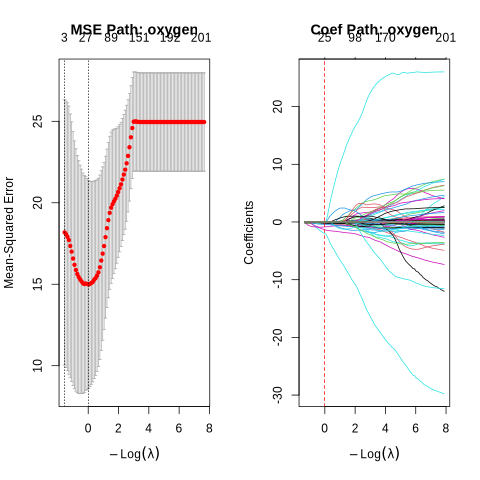

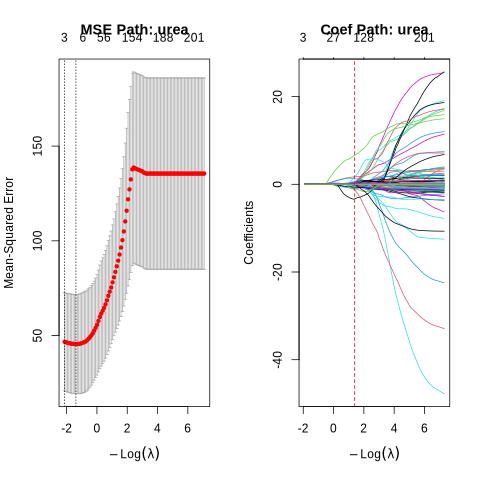

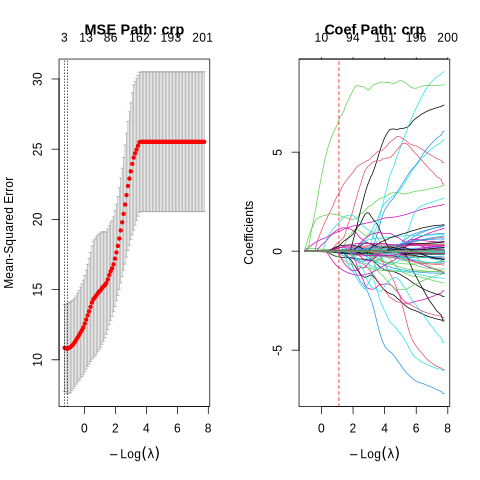

In [8]:
%%R
# -------------------------------------------------------------
# 3. Main
# -------------------------------------------------------------

for (target_var in names(target_files)) {
    
    csv_file <- target_files[[target_var]]
    
    print(paste("=========================================="))
    print(paste("Processing Target:", target_var))
    print(paste("Loading File:", csv_file))
    print(paste("=========================================="))
    
    ddd <- read.csv(csv_file)
    
    if("oxygen" %in% names(ddd)) ddd$oxygen <- as.numeric(ddd$oxygen)
    if("crp" %in% names(ddd))    ddd$crp <- as.numeric(ddd$crp)
    if("urea" %in% names(ddd))   ddd$urea <- as.numeric(ddd$urea)
    if("severity" %in% names(ddd)) ddd$severity <- as.numeric(ddd$severity)
    
    ddd$age <- as.numeric(ddd$age)
    ddd$sex <- as.factor(ddd$sex)
    ddd$bmi <- as.numeric(ddd$bmi)
    ddd$days <- as.numeric(ddd$days)
    ddd$ID <- as.factor(ddd$ID)
    
    set.seed(42)
    unique_ids <- unique(ddd$ID)
    train_ids <- sample(unique_ids, size = floor(0.7 * length(unique_ids)))
    test_ids <- setdiff(unique_ids, train_ids)
    
    train_full <- ddd %>% filter(ID %in% train_ids)
    test_full <- ddd %>% filter(ID %in% test_ids)
    
    # -------------------------------------------------------
    # 4. filtering
    # -------------------------------------------------------
    
    # 4-1. (Correlation > 0.7)
    cols_numeric <- sapply(train_full, is.numeric)
    exclude_from_corr <- c("oxygen", "crp", "urea", "severity", "ID", "time")
    cols_check <- setdiff(names(train_full)[cols_numeric], exclude_from_corr)
    
    if(length(cols_check) > 1) {
        cor_matrix <- cor(train_full[, cols_check], use = "pairwise.complete.obs")
        highly_correlated <- which(abs(cor_matrix) > 0.7, arr.ind = TRUE)
        to_remove_corr <- highly_correlated[highly_correlated[, 1] != highly_correlated[, 2], ]
        
        if(nrow(to_remove_corr) > 0) {
            remove_vars <- unique(rownames(cor_matrix)[to_remove_corr[, 1]])
            print(paste("Removed high correlation vars:", length(remove_vars)))
            train_full <- train_full[, !names(train_full) %in% remove_vars]
        }
    }
    
    cols_in <- grep("in", names(train_full), value = TRUE)
    cols_protein <- grep("Protein", names(train_full), value = TRUE)
    cols_remove_name <- setdiff(cols_in, cols_protein)
    
    if(length(cols_remove_name) > 0) {
        print(paste("Removed 'in' pattern variables:", length(cols_remove_name)))
        train_full <- train_full[, !names(train_full) %in% cols_remove_name]
    }
    
    # -------------------------------------------------------
    # 5. Elastic Net
    # -------------------------------------------------------
    
    train_sub <- train_full[!is.na(train_full[[target_var]]), ]
    
    exclude_vars <- c("ID", "time", "severity", "oxygen", "urea", "crp")
    exclude_actual <- intersect(exclude_vars, names(train_sub))
    
    predictors <- setdiff(names(train_sub), exclude_actual)
    
    formula_str <- paste(target_var, "~", paste(predictors, collapse = " + "))
    fixed_formula <- as.formula(formula_str)
    
    train_x <- model.matrix(fixed_formula, data = train_sub)[, -1]
    train_y <- train_sub[[target_var]]
    
    # Penalty Factor 
    current_vars <- colnames(train_x)
    penalty_factors <- rep(1, length(current_vars))
    
    valid_mandatory <- intersect(mandatory_vars, current_vars)
    if(length(valid_mandatory) > 0) {
        penalty_factors[current_vars %in% valid_mandatory] <- 0
        print(paste("Mandatory variables (penalty=0):", paste(valid_mandatory, collapse=", ")))
    }
    
    set.seed(42)
    model_cv <- cv.glmnet(
        x = train_x,
        y = train_y,
        alpha = 0.4,       # Elastic Net
        family = "gaussian", 
        penalty.factor = penalty_factors,
        nfolds = 5
    )
    
    optimal_lambda <- model_cv$lambda.min
    print(paste("Optimal Lambda:", optimal_lambda))
    
    coef_values <- coef(model_cv, s = "lambda.min")
    coef_mat <- as.matrix(coef_values)
    
    non_zero_idx <- which(coef_mat != 0)
    non_zero_names <- rownames(coef_mat)[non_zero_idx]
    non_zero_vals <- coef_mat[non_zero_idx]
    
    lmin_df <- data.frame(Variable = non_zero_names, Coefficient = non_zero_vals)
    lmin_df <- lmin_df %>% filter(Variable != "(Intercept)")
    
    filename <- paste0("lmin_", target_var, ".csv")
    write.csv(lmin_df, file = filename, row.names = FALSE)
    print(paste("Saved:", filename))
    print(head(lmin_df))
    
    par(mfrow=c(1,2))
    plot(model_cv, main = paste("MSE Path:", target_var))
    
    final_model <- glmnet(train_x, train_y, alpha = 0.4, family = "gaussian", penalty.factor = penalty_factors)
    plot(final_model, xvar = "lambda", label = TRUE, main = paste("Coef Path:", target_var))
    abline(v = log(optimal_lambda), col = "red", lty = 2)
    par(mfrow=c(1,1))
    
    print("------------------------------------------")
}